# DenoiSeg Example: Fly Wing
This is an example notebook which illustrates how DenoiSeg should be trained. In this notebook we use a membrane labeled developing Fly Wing dataset from our collaborators. We already split the data into train and test images. From the train images we then extracted 1428 training and 252 validation patches of size 128x128. The test set contains 50 images of size 512x512.

In [1]:
# Here we are just importing some libraries which are needed to run this notebook.
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage

from denoiseg.models import DenoiSeg, DenoiSegConfig
from denoiseg.utils.misc_utils import combine_train_test_data, shuffle_train_data, augment_data
from denoiseg.utils.seg_utils import *
from denoiseg.utils.compute_precision_threshold import measure_precision

from csbdeep.utils import plot_history

import urllib
import os
import zipfile

Using TensorFlow backend.
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/pr

## Downloading and  Data Loading
We created three versions of this dataset by adding Gaussian noise with zero mean and standard deviations 10 and 20. The dataset are marked with the suffixes n0, n10 and n20 accordingly.

In the next cell you can choose which `noise_level` you would like to investigate.

In [2]:
# Choose the noise level you would like to look at:
# Values: 'n0', 'n10', 'n20'
noise_level = 'n10'

In [3]:
# create a folder for our data
if not os.path.isdir('./data'):
    os.mkdir('data')
    
if noise_level == 'n0':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/1WXxLSqbK0ZIxF5/download'
elif noise_level == 'n10':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/llTDhwvxgmDdQ3B/download'
elif noise_level == 'n20':
    link = 'https://owncloud.mpi-cbg.de/index.php/s/s1XEtPnKTvR64aG/download'
else:
    print('This noise level does not exist for this dataset.')

# check if data has been downloaded already
zipPath="data/Flywing_{}.zip".format(noise_level)
if not os.path.exists(zipPath):
    #download and unzip data
    data = urllib.request.urlretrieve(link, zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

In [4]:
# Loading of the training images
trainval_data =  np.load('data/Flywing_{}/train/train_data.npz'.format(noise_level))
train_images = trainval_data['X_train'].astype(np.float32)
train_masks = trainval_data['Y_train']
val_images = trainval_data['X_val'].astype(np.float32)
val_masks = trainval_data['Y_val']

In [5]:
print("Shape of train_images: {}".format(train_images.shape))
print("Shape of train_masks:  {}".format(train_masks.shape))
print("Shape of val_images:   {}".format(val_images.shape))
print("Shape of val_masks:    {}".format(val_masks.shape))

Shape of train_images: (1428, 128, 128)
Shape of train_masks:  (1428, 128, 128)
Shape of val_images:   (252, 128, 128)
Shape of val_masks:    (252, 128, 128)


## Small Amounts of Annotated Training Data
With DenoiSeg we present a solution to train deep neural networks if only few annotated ground truth segmentations are available. We simulate such a scenario by zeroing out all but a fraction of the available training data. In the next cell you can specify the percentage of training images for which ground truth annotations are available.

In [6]:
# Set the percentage of annotated training images.
# Values: 0.0 (no annotated images) to 100.0 (all images get annotations)
percentage_of_annotated_training_images = 0.25
assert percentage_of_annotated_training_images >= 0.0 and percentage_of_annotated_training_images <=100.0

In [7]:
# Seed to shuffle training data (annotated GT and raw image pairs).
seed = 1 

# First we shuffle the training images to remove any bias.
X_shuffled, Y_shuffled = shuffle_train_data(train_images, train_masks, random_seed=seed)
# Here we zero out all training images which are not part of the 
# selected percentage.
X_frac, Y_frac = zero_out_train_data(X_shuffled, Y_shuffled, fraction = percentage_of_annotated_training_images)

# Now we apply data augmentation to the training patches:
# Rotate four times by 90 degree and add flipped versions.
X, Y_train_masks = augment_data(X_frac, Y_frac)
X_val, Y_val_masks = val_images, val_masks

# Here we add the channel dimension to our input images.
# Dimensionality for training has to be 'SYXC' (Sample, Y-Dimension, X-Dimension, Channel)
X = X[...,np.newaxis]
Y = convert_to_oneHot(Y_train_masks)
X_val = X_val[...,np.newaxis]
Y_val = convert_to_oneHot(Y_val_masks)
print("Shape of X:     {}".format(X.shape))
print("Shape of Y:     {}".format(Y.shape))
print("Shape of X_val: {}".format(X_val.shape))
print("Shape of Y_val: {}".format(Y_val.shape))

Raw image size after augmentation (11424, 128, 128)
Mask size after augmentation (11424, 128, 128)
Shape of X:     (11424, 128, 128, 1)
Shape of Y:     (11424, 128, 128, 3)
Shape of X_val: (252, 128, 128, 1)
Shape of Y_val: (252, 128, 128, 3)


Next we look at a single sample. In the first column we show the input image, in the second column the background segmentation, in the third column the foreground segmentation and in the last column the border segmentation.

With the parameter `sample` you can choose different training patches. You will notice that not all of them have a segmentation ground truth.

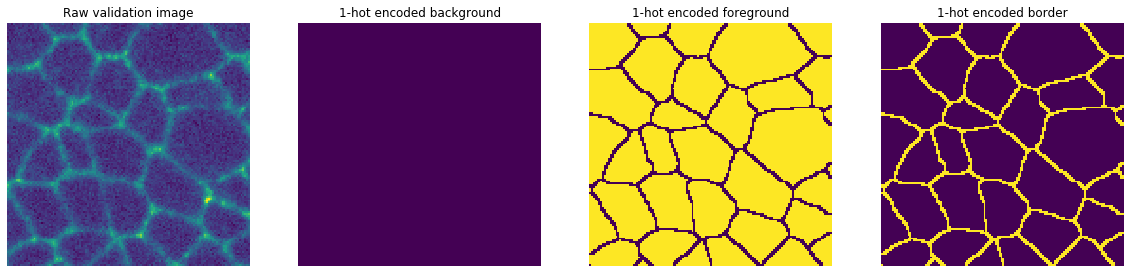

In [8]:
sample = 0
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.imshow(X[sample,...,0])
plt.axis('off')
plt.title('Raw validation image')
plt.subplot(1,4,2)
plt.imshow(Y[sample,...,0], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded background')
plt.subplot(1,4,3)
plt.imshow(Y[sample,...,1], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded foreground')
plt.subplot(1,4,4)
plt.imshow(Y[sample,...,2], vmin=0, vmax=1, interpolation='nearest')
plt.axis('off')
plt.title('1-hot encoded border');

### Configure network parameters

In [9]:
train_batch_size = 128
train_steps_per_epoch = max(100, min(int(X.shape[0]/train_batch_size), 400))

In [ ]:
### In the next cell, you can choose how much relative importance (weight) to assign to denoising 
### and segmentation tasks by choosing appropriate value for denoiseg_alpha (between 0 and 1; with 0 being
### only segmentation and 1 being only denoising. Here we choose denoiseg_alpha = 0.5)

In [10]:
conf = DenoiSegConfig(X, unet_kern_size=3, n_channel_out=4, relative_weights = [1.0,1.0,5.0],
                      train_steps_per_epoch=train_steps_per_epoch, train_epochs=200, 
                      batch_norm=True, train_batch_size=128, unet_n_first = 32, 
                      unet_n_depth=4, denoiseg_alpha=0.5, train_tensorboard=False)

vars(conf)

{'means': ['44.538273'],
 'stds': ['40.435387'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 4,
 'train_loss': 'denoiseg',
 'unet_n_depth': 4,
 'relative_weights': [1.0, 1.0, 5.0],
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'probabilistic': False,
 'unet_residual': False,
 'unet_input_shape': (None, None, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': False,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'train_reduce_lr': {'monitor': 'val_loss', 'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 1.5,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'denoiseg_alpha': 0.5}

In [11]:
model_name = 'DenoiSeg_Flywing_n10'
basedir = 'models'
model = DenoiSeg(conf, model_name, basedir)

In [12]:
history = model.train(X, Y, (X_val, Y_val))

/home/prakash/Desktop/GitClones/DenoiSeg/denoiseg/models/denoiseg_standard.py:146: UserWarning: small number of validation images (only 2.15827% of all images)
  warnings.warn("small number of validation images (only %.05f%% of all images)" % (100 * frac_val))
Preparing validation data:   1%|          | 2/252 [00:00<00:14, 17.82it/s]

61 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 252/252 [00:06<00:00, 36.14it/s]


Epoch 1/200
100/100 [==============================] - 104s 1s/step - loss: 0.1003 - denoiseg: 0.1003 - seg_loss: 0.0018 - denoise_loss: 0.0986 - val_loss: 1.1673 - val_denoiseg: 1.1673 - val_seg_loss: 1.0783 - val_denoise_loss: 0.0890
Epoch 2/200
100/100 [==============================] - 94s 936ms/step - loss: 0.0518 - denoiseg: 0.0518 - seg_loss: 0.0014 - denoise_loss: 0.0504 - val_loss: 0.9583 - val_denoiseg: 0.9583 - val_seg_loss: 0.8919 - val_denoise_loss: 0.0664
Epoch 3/200
100/100 [==============================] - 106s 1s/step - loss: 0.0486 - denoiseg: 0.0486 - seg_loss: 0.0011 - denoise_loss: 0.0475 - val_loss: 0.8418 - val_denoiseg: 0.8418 - val_seg_loss: 0.7866 - val_denoise_loss: 0.0553
Epoch 4/200
100/100 [==============================] - 112s 1s/step - loss: 0.0474 - denoiseg: 0.0474 - seg_loss: 0.0013 - denoise_loss: 0.0461 - val_loss: 0.7919 - val_denoiseg: 0.7919 - val_seg_loss: 0.7423 - val_denoise_loss: 0.0495
Epoch 5/200
100/100 [==============================] -

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299548). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.154358). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 92s 919ms/step - loss: 0.0442 - denoiseg: 0.0442 - seg_loss: 7.9472e-04 - denoise_loss: 0.0434 - val_loss: 0.9143 - val_denoiseg: 0.9143 - val_seg_loss: 0.8720 - val_denoise_loss: 0.0423
Epoch 12/200
100/100 [==============================] - 94s 943ms/step - loss: 0.0441 - denoiseg: 0.0441 - seg_loss: 7.3416e-04 - denoise_loss: 0.0434 - val_loss: 1.0312 - val_denoiseg: 1.0312 - val_seg_loss: 0.9880 - val_denoise_loss: 0.0431
Epoch 13/200
  1/100 [..............................] - ETA: 12s - loss: 0.0434 - denoiseg: 0.0434 - seg_loss: 0.0000e+00 - denoise_loss: 0.0434

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134682). Check your callbacks.
  % delta_t_median)


  3/100 [..............................] - ETA: 1:01 - loss: 0.0438 - denoiseg: 0.0438 - seg_loss: 7.1515e-04 - denoise_loss: 0.0430

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118923). Check your callbacks.
  % delta_t_median)


  4/100 [>.............................] - ETA: 1:07 - loss: 0.0443 - denoiseg: 0.0443 - seg_loss: 5.3636e-04 - denoise_loss: 0.0437

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.111990). Check your callbacks.
  % delta_t_median)


  7/100 [=>............................] - ETA: 1:14 - loss: 0.0436 - denoiseg: 0.0436 - seg_loss: 5.2091e-04 - denoise_loss: 0.0431

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105056). Check your callbacks.
  % delta_t_median)


 10/100 [==>...........................] - ETA: 1:15 - loss: 0.0442 - denoiseg: 0.0442 - seg_loss: 0.0011 - denoise_loss: 0.0431    

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101566). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 91s 914ms/step - loss: 0.0440 - denoiseg: 0.0440 - seg_loss: 7.2186e-04 - denoise_loss: 0.0433 - val_loss: 0.8318 - val_denoiseg: 0.8318 - val_seg_loss: 0.7885 - val_denoise_loss: 0.0432
Epoch 14/200
100/100 [==============================] - 92s 923ms/step - loss: 0.0437 - denoiseg: 0.0437 - seg_loss: 7.3955e-04 - denoise_loss: 0.0429 - val_loss: 0.7221 - val_denoiseg: 0.7221 - val_seg_loss: 0.6797 - val_denoise_loss: 0.0424
Epoch 15/200
100/100 [==============================] - 90s 897ms/step - loss: 0.0438 - denoiseg: 0.0438 - seg_loss: 7.8077e-04 - denoise_loss: 0.0430 - val_loss: 1.1496 - val_denoiseg: 1.1496 - val_seg_loss: 1.1066 - val_denoise_loss: 0.0430
Epoch 16/200
100/100 [==============================] - 105s 1s/step - loss: 0.0435 - denoiseg: 0.0435 - seg_loss: 6.0947e-04 - denoise_loss: 0.0429 - val_loss: 0.6705 - val_denoiseg: 0.6705 - val_seg_loss: 0.6269 - val_denoise_loss: 0.0436
Epoch 17/200
100/100 [=====================

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102763). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 102s 1s/step - loss: 0.0431 - denoiseg: 0.0431 - seg_loss: 6.2475e-04 - denoise_loss: 0.0425 - val_loss: 1.0547 - val_denoiseg: 1.0547 - val_seg_loss: 1.0121 - val_denoise_loss: 0.0426
Epoch 22/200
 35/100 [=========>....................] - ETA: 55s - loss: 0.0431 - denoiseg: 0.0431 - seg_loss: 6.1401e-04 - denoise_loss: 0.0424

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.112054). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 97s 974ms/step - loss: 0.0431 - denoiseg: 0.0431 - seg_loss: 5.7185e-04 - denoise_loss: 0.0425 - val_loss: 0.7593 - val_denoiseg: 0.7593 - val_seg_loss: 0.7173 - val_denoise_loss: 0.0421
Epoch 23/200
100/100 [==============================] - 109s 1s/step - loss: 0.0431 - denoiseg: 0.0431 - seg_loss: 6.8035e-04 - denoise_loss: 0.0424 - val_loss: 0.7517 - val_denoiseg: 0.7517 - val_seg_loss: 0.7099 - val_denoise_loss: 0.0418
Epoch 24/200
  1/100 [..............................] - ETA: 10s - loss: 0.0430 - denoiseg: 0.0430 - seg_loss: 0.0000e+00 - denoise_loss: 0.0430

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.140786). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 95s 954ms/step - loss: 0.0430 - denoiseg: 0.0430 - seg_loss: 6.2463e-04 - denoise_loss: 0.0424 - val_loss: 0.8388 - val_denoiseg: 0.8388 - val_seg_loss: 0.7970 - val_denoise_loss: 0.0417
Epoch 25/200
100/100 [==============================] - 103s 1s/step - loss: 0.0428 - denoiseg: 0.0428 - seg_loss: 5.5037e-04 - denoise_loss: 0.0423 - val_loss: 0.7456 - val_denoiseg: 0.7456 - val_seg_loss: 0.7044 - val_denoise_loss: 0.0413
Epoch 26/200
100/100 [==============================] - 105s 1s/step - loss: 0.0430 - denoiseg: 0.0430 - seg_loss: 7.0232e-04 - denoise_loss: 0.0423 - val_loss: 0.8398 - val_denoiseg: 0.8398 - val_seg_loss: 0.7971 - val_denoise_loss: 0.0427

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.00019999999494757503.
Epoch 27/200
100/100 [==============================] - 109s 1s/step - loss: 0.0427 - denoiseg: 0.0427 - seg_loss: 5.9521e-04 - denoise_loss: 0.0421 - val_loss: 0.7023 - val_denoiseg: 0.7023 - val_seg_loss:

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.138301). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 93s 933ms/step - loss: 0.0424 - denoiseg: 0.0424 - seg_loss: 5.1803e-04 - denoise_loss: 0.0419 - val_loss: 0.7380 - val_denoiseg: 0.7380 - val_seg_loss: 0.6967 - val_denoise_loss: 0.0414
Epoch 30/200
100/100 [==============================] - 99s 985ms/step - loss: 0.0425 - denoiseg: 0.0425 - seg_loss: 6.7378e-04 - denoise_loss: 0.0418 - val_loss: 0.9233 - val_denoiseg: 0.9233 - val_seg_loss: 0.8821 - val_denoise_loss: 0.0412
Epoch 31/200
100/100 [==============================] - 94s 940ms/step - loss: 0.0426 - denoiseg: 0.0426 - seg_loss: 6.1240e-04 - denoise_loss: 0.0420 - val_loss: 0.7038 - val_denoiseg: 0.7038 - val_seg_loss: 0.6626 - val_denoise_loss: 0.0411
Epoch 32/200
100/100 [==============================] - 92s 923ms/step - loss: 0.0428 - denoiseg: 0.0428 - seg_loss: 7.2133e-04 - denoise_loss: 0.0421 - val_loss: 0.6131 - val_denoiseg: 0.6131 - val_seg_loss: 0.5716 - val_denoise_loss: 0.0415
Epoch 33/200
100/100 [===================

Epoch 63/200
100/100 [==============================] - 107s 1s/step - loss: 0.0421 - denoiseg: 0.0421 - seg_loss: 5.7326e-04 - denoise_loss: 0.0415 - val_loss: 0.6118 - val_denoiseg: 0.6118 - val_seg_loss: 0.5707 - val_denoise_loss: 0.0411
Epoch 64/200
100/100 [==============================] - 99s 985ms/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.3746e-04 - denoise_loss: 0.0414 - val_loss: 0.8229 - val_denoiseg: 0.8229 - val_seg_loss: 0.7819 - val_denoise_loss: 0.0410
Epoch 65/200
100/100 [==============================] - 110s 1s/step - loss: 0.0421 - denoiseg: 0.0421 - seg_loss: 4.8575e-04 - denoise_loss: 0.0416 - val_loss: 0.5853 - val_denoiseg: 0.5853 - val_seg_loss: 0.5445 - val_denoise_loss: 0.0408

Epoch 00065: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 66/200
100/100 [==============================] - 113s 1s/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.7406e-04 - denoise_loss: 0.0414 - val_loss: 0.3544 - val_denoiseg: 0.3544 - v

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107762). Check your callbacks.
  % delta_t_median)


 73/100 [====================>.........] - ETA: 24s - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.6769e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101680). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 94s 943ms/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.5255e-04 - denoise_loss: 0.0414 - val_loss: 0.5153 - val_denoiseg: 0.5153 - val_seg_loss: 0.4744 - val_denoise_loss: 0.0408
Epoch 76/200
100/100 [==============================] - 92s 924ms/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.3262e-04 - denoise_loss: 0.0414 - val_loss: 0.5826 - val_denoiseg: 0.5826 - val_seg_loss: 0.5416 - val_denoise_loss: 0.0410
Epoch 77/200
100/100 [==============================] - 107s 1s/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.5221e-04 - denoise_loss: 0.0414 - val_loss: 0.5439 - val_denoiseg: 0.5439 - val_seg_loss: 0.5032 - val_denoise_loss: 0.0408

Epoch 00077: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 78/200
100/100 [==============================] - 110s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.4054e-04 - denoise_loss: 0.0411 - val_loss: 0.5476 - val_denoiseg: 0.5476 - val_seg_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108232). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 94s 938ms/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 5.5690e-04 - denoise_loss: 0.0413 - val_loss: 0.4674 - val_denoiseg: 0.4674 - val_seg_loss: 0.4266 - val_denoise_loss: 0.0408
Epoch 82/200
100/100 [==============================] - 98s 984ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.8890e-04 - denoise_loss: 0.0413 - val_loss: 0.5626 - val_denoiseg: 0.5626 - val_seg_loss: 0.5219 - val_denoise_loss: 0.0408
Epoch 83/200
100/100 [==============================] - 113s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.0779e-04 - denoise_loss: 0.0411 - val_loss: 0.5077 - val_denoiseg: 0.5077 - val_seg_loss: 0.4668 - val_denoise_loss: 0.0409
Epoch 84/200
100/100 [==============================] - 118s 1s/step - loss: 0.0420 - denoiseg: 0.0420 - seg_loss: 6.1219e-04 - denoise_loss: 0.0414 - val_loss: 0.7434 - val_denoiseg: 0.7434 - val_seg_loss: 0.7026 - val_denoise_loss: 0.0408
Epoch 85/200
100/100 [=======================

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113526). Check your callbacks.
  % delta_t_median)


 92/100 [==========================>...] - ETA: 7s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.9636e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.124876). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 92s 924ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.7782e-04 - denoise_loss: 0.0412 - val_loss: 0.5450 - val_denoiseg: 0.5450 - val_seg_loss: 0.5043 - val_denoise_loss: 0.0408
Epoch 89/200
 58/100 [================>.............] - ETA: 38s - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 3.3216e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.126291). Check your callbacks.
  % delta_t_median)


 60/100 [=================>............] - ETA: 36s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 3.8151e-04 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104532). Check your callbacks.
  % delta_t_median)


 61/100 [=================>............] - ETA: 35s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 3.7526e-04 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.109219). Check your callbacks.
  % delta_t_median)


 80/100 [=======================>......] - ETA: 18s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.9865e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100085). Check your callbacks.
  % delta_t_median)


 81/100 [=======================>......] - ETA: 17s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.9249e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.118098). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 93s 932ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.9107e-04 - denoise_loss: 0.0413 - val_loss: 0.5278 - val_denoiseg: 0.5278 - val_seg_loss: 0.4870 - val_denoise_loss: 0.0408
Epoch 90/200
 39/100 [==========>...................] - ETA: 54s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.8583e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101036). Check your callbacks.
  % delta_t_median)


 41/100 [===========>..................] - ETA: 53s - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.6213e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.117213). Check your callbacks.
  % delta_t_median)


 43/100 [===========>..................] - ETA: 51s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.3988e-04 - denoise_loss: 0.0413

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.143200). Check your callbacks.
  % delta_t_median)


 57/100 [================>.............] - ETA: 38s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.5781e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100702). Check your callbacks.
  % delta_t_median)


 59/100 [================>.............] - ETA: 36s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.6682e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106715). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 91s 908ms/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.8155e-04 - denoise_loss: 0.0413 - val_loss: 0.5881 - val_denoiseg: 0.5881 - val_seg_loss: 0.5473 - val_denoise_loss: 0.0408
Epoch 91/200
  3/100 [..............................] - ETA: 1:02 - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 0.0000e+00 - denoise_loss: 0.0415

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123806). Check your callbacks.
  % delta_t_median)


  6/100 [>.............................] - ETA: 1:12 - loss: 0.0414 - denoiseg: 0.0414 - seg_loss: 0.0000e+00 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128777). Check your callbacks.
  % delta_t_median)


  7/100 [=>............................] - ETA: 1:13 - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 0.0000e+00 - denoise_loss: 0.0415

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.133749). Check your callbacks.
  % delta_t_median)


  8/100 [=>............................] - ETA: 1:13 - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 2.0786e-04 - denoise_loss: 0.0416

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.153093). Check your callbacks.
  % delta_t_median)


 10/100 [==>...........................] - ETA: 1:14 - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 1.6628e-04 - denoise_loss: 0.0417

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.128802). Check your callbacks.
  % delta_t_median)


 12/100 [==>...........................] - ETA: 1:14 - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 3.7629e-04 - denoise_loss: 0.0415

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.148147). Check your callbacks.
  % delta_t_median)


 14/100 [===>..........................] - ETA: 1:13 - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.2499e-04 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152282). Check your callbacks.
  % delta_t_median)


 16/100 [===>..........................] - ETA: 1:12 - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.5097e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.127991). Check your callbacks.
  % delta_t_median)


 18/100 [====>.........................] - ETA: 1:11 - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.8975e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114810). Check your callbacks.
  % delta_t_median)


 21/100 [=====>........................] - ETA: 1:06 - loss: 0.0430 - denoiseg: 0.0430 - seg_loss: 4.1978e-04 - denoise_loss: 0.0426

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107656). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 93s 932ms/step - loss: 0.0421 - denoiseg: 0.0421 - seg_loss: 5.2911e-04 - denoise_loss: 0.0415 - val_loss: 0.8715 - val_denoiseg: 0.8715 - val_seg_loss: 0.8307 - val_denoise_loss: 0.0408
Epoch 92/200
100/100 [==============================] - 104s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.5605e-04 - denoise_loss: 0.0413 - val_loss: 0.6730 - val_denoiseg: 0.6730 - val_seg_loss: 0.6322 - val_denoise_loss: 0.0408
Epoch 93/200
100/100 [==============================] - 112s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.2495e-04 - denoise_loss: 0.0412 - val_loss: 0.5991 - val_denoiseg: 0.5991 - val_seg_loss: 0.5583 - val_denoise_loss: 0.0408
Epoch 94/200
100/100 [==============================] - 110s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.0350e-04 - denoise_loss: 0.0412 - val_loss: 0.5950 - val_denoiseg: 0.5950 - val_seg_loss: 0.5543 - val_denoise_loss: 0.0408
Epoch 95/200
100/100 [=========================

Epoch 124/200
  3/100 [..............................] - ETA: 1:05 - loss: 0.0420 - denoiseg: 0.0420 - seg_loss: 3.4332e-04 - denoise_loss: 0.0417

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.125451). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 100s 998ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.0529e-04 - denoise_loss: 0.0413 - val_loss: 0.5577 - val_denoiseg: 0.5577 - val_seg_loss: 0.5169 - val_denoise_loss: 0.0408
Epoch 125/200
100/100 [==============================] - 110s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.4418e-04 - denoise_loss: 0.0411 - val_loss: 0.5542 - val_denoiseg: 0.5542 - val_seg_loss: 0.5135 - val_denoise_loss: 0.0408
Epoch 126/200
100/100 [==============================] - 113s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.5426e-04 - denoise_loss: 0.0411 - val_loss: 0.5738 - val_denoiseg: 0.5738 - val_seg_loss: 0.5331 - val_denoise_loss: 0.0408
Epoch 127/200
100/100 [==============================] - 115s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.1676e-04 - denoise_loss: 0.0412 - val_loss: 0.5488 - val_denoiseg: 0.5488 - val_seg_loss: 0.5081 - val_denoise_loss: 0.0408

Epoch 00127: ReduceLROnPlateau reducing le

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100208). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 115s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.4241e-04 - denoise_loss: 0.0414 - val_loss: 0.5718 - val_denoiseg: 0.5718 - val_seg_loss: 0.5310 - val_denoise_loss: 0.0407
Epoch 133/200
  4/100 [>.............................] - ETA: 57s - loss: 0.0425 - denoiseg: 0.0425 - seg_loss: 8.0774e-04 - denoise_loss: 0.0417

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100712). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 109s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 6.1585e-04 - denoise_loss: 0.0412 - val_loss: 0.5658 - val_denoiseg: 0.5658 - val_seg_loss: 0.5251 - val_denoise_loss: 0.0408
Epoch 134/200
100/100 [==============================] - 117s 1s/step - loss: 0.0414 - denoiseg: 0.0414 - seg_loss: 4.6582e-04 - denoise_loss: 0.0410 - val_loss: 0.5644 - val_denoiseg: 0.5644 - val_seg_loss: 0.5237 - val_denoise_loss: 0.0408
Epoch 135/200
100/100 [==============================] - 107s 1s/step - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 5.2568e-04 - denoise_loss: 0.0410 - val_loss: 0.5744 - val_denoiseg: 0.5744 - val_seg_loss: 0.5336 - val_denoise_loss: 0.0407
Epoch 136/200
100/100 [==============================] - 111s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.4124e-04 - denoise_loss: 0.0412 - val_loss: 0.5699 - val_denoiseg: 0.5699 - val_seg_loss: 0.5291 - val_denoise_loss: 0.0408
Epoch 137/200
100/100 [=======================

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.145885). Check your callbacks.
  % delta_t_median)
/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108012). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 98s 980ms/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.4933e-04 - denoise_loss: 0.0411 - val_loss: 0.5615 - val_denoiseg: 0.5615 - val_seg_loss: 0.5207 - val_denoise_loss: 0.0407
Epoch 140/200
 26/100 [======>.......................] - ETA: 1:03 - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 3.7627e-04 - denoise_loss: 0.0411

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114539). Check your callbacks.
  % delta_t_median)


 31/100 [========>.....................] - ETA: 59s - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.2153e-04 - denoise_loss: 0.0411 

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108005). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 90s 905ms/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.1560e-04 - denoise_loss: 0.0412 - val_loss: 0.5658 - val_denoiseg: 0.5658 - val_seg_loss: 0.5251 - val_denoise_loss: 0.0408
Epoch 141/200
100/100 [==============================] - 92s 922ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.1849e-04 - denoise_loss: 0.0412 - val_loss: 0.5555 - val_denoiseg: 0.5555 - val_seg_loss: 0.5147 - val_denoise_loss: 0.0407
Epoch 142/200
100/100 [==============================] - 114s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.5074e-04 - denoise_loss: 0.0412 - val_loss: 0.5527 - val_denoiseg: 0.5527 - val_seg_loss: 0.5119 - val_denoise_loss: 0.0407
Epoch 143/200
100/100 [==============================] - 110s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.5798e-04 - denoise_loss: 0.0411 - val_loss: 0.5592 - val_denoiseg: 0.5592 - val_seg_loss: 0.5184 - val_denoise_loss: 0.0408
Epoch 144/200
100/100 [===================

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100867). Check your callbacks.
  % delta_t_median)


 88/100 [=========================>....] - ETA: 13s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 6.2507e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120523). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 110s 1s/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 6.1988e-04 - denoise_loss: 0.0412 - val_loss: 0.5531 - val_denoiseg: 0.5531 - val_seg_loss: 0.5124 - val_denoise_loss: 0.0408
Epoch 161/200
  2/100 [..............................] - ETA: 21s - loss: 0.0399 - denoiseg: 0.0399 - seg_loss: 0.0000e+00 - denoise_loss: 0.039 - ETA: 23s - loss: 0.0401 - denoiseg: 0.0401 - seg_loss: 0.0000e+00 - denoise_loss: 0.0401

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101279). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 94s 943ms/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.9303e-04 - denoise_loss: 0.0412 - val_loss: 0.5587 - val_denoiseg: 0.5587 - val_seg_loss: 0.5180 - val_denoise_loss: 0.0407
Epoch 162/200
100/100 [==============================] - 111s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.1616e-04 - denoise_loss: 0.0413 - val_loss: 0.5645 - val_denoiseg: 0.5645 - val_seg_loss: 0.5237 - val_denoise_loss: 0.0408
Epoch 163/200
  5/100 [>.............................] - ETA: 52s - loss: 0.0414 - denoiseg: 0.0414 - seg_loss: 2.9898e-04 - denoise_loss: 0.0411

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.101491). Check your callbacks.
  % delta_t_median)


 41/100 [===========>..................] - ETA: 52s - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.1955e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103347). Check your callbacks.
  % delta_t_median)


 44/100 [============>.................] - ETA: 49s - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.8413e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120276). Check your callbacks.
  % delta_t_median)


 46/100 [============>.................] - ETA: 48s - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.6308e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.134032). Check your callbacks.
  % delta_t_median)


 48/100 [=============>................] - ETA: 46s - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.6591e-04 - denoise_loss: 0.0412

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123012). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 93s 927ms/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.4268e-04 - denoise_loss: 0.0413 - val_loss: 0.5581 - val_denoiseg: 0.5581 - val_seg_loss: 0.5173 - val_denoise_loss: 0.0408
Epoch 164/200
  5/100 [>.............................] - ETA: 55s - loss: 0.0411 - denoiseg: 0.0411 - seg_loss: 0.0000e+00 - denoise_loss: 0.0411

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.132168). Check your callbacks.
  % delta_t_median)


 11/100 [==>...........................] - ETA: 1:07 - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 3.3937e-04 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107955). Check your callbacks.
  % delta_t_median)


 63/100 [=================>............] - ETA: 33s - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 4.5473e-04 - denoise_loss: 0.0410

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104199). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 91s 908ms/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.0811e-04 - denoise_loss: 0.0411 - val_loss: 0.5671 - val_denoiseg: 0.5671 - val_seg_loss: 0.5264 - val_denoise_loss: 0.0408
Epoch 165/200
100/100 [==============================] - 106s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.5519e-04 - denoise_loss: 0.0412 - val_loss: 0.5639 - val_denoiseg: 0.5639 - val_seg_loss: 0.5231 - val_denoise_loss: 0.0408
Epoch 166/200
  1/100 [..............................] - ETA: 12s - loss: 0.0426 - denoiseg: 0.0426 - seg_loss: 0.0016 - denoise_loss: 0.0410

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170322). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 108s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.6912e-04 - denoise_loss: 0.0412 - val_loss: 0.5621 - val_denoiseg: 0.5621 - val_seg_loss: 0.5213 - val_denoise_loss: 0.0408
Epoch 167/200
100/100 [==============================] - 109s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.8754e-04 - denoise_loss: 0.0411 - val_loss: 0.5637 - val_denoiseg: 0.5637 - val_seg_loss: 0.5230 - val_denoise_loss: 0.0408

Epoch 00167: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.
Epoch 168/200
  5/100 [>.............................] - ETA: 1:10 - loss: 0.0411 - denoiseg: 0.0411 - seg_loss: 5.4463e-04 - denoise_loss: 0.0406

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.104036). Check your callbacks.
  % delta_t_median)


 50/100 [==============>...............] - ETA: 44s - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 4.3916e-04 - denoise_loss: 0.0411

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107293). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 94s 941ms/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.5960e-04 - denoise_loss: 0.0412 - val_loss: 0.5691 - val_denoiseg: 0.5691 - val_seg_loss: 0.5284 - val_denoise_loss: 0.0408
Epoch 169/200
100/100 [==============================] - 108s 1s/step - loss: 0.0419 - denoiseg: 0.0419 - seg_loss: 6.2503e-04 - denoise_loss: 0.0413 - val_loss: 0.5721 - val_denoiseg: 0.5721 - val_seg_loss: 0.5313 - val_denoise_loss: 0.0408
Epoch 170/200
  2/100 [..............................] - ETA: 53s - loss: 0.0410 - denoiseg: 0.0410 - seg_loss: 5.8544e-04 - denoise_loss: 0.0404

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120751). Check your callbacks.
  % delta_t_median)


  3/100 [..............................] - ETA: 1:05 - loss: 0.0408 - denoiseg: 0.0408 - seg_loss: 3.9029e-04 - denoise_loss: 0.0405

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152241). Check your callbacks.
  % delta_t_median)


  4/100 [>.............................] - ETA: 1:15 - loss: 0.0406 - denoiseg: 0.0406 - seg_loss: 2.9272e-04 - denoise_loss: 0.0403

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107557). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 117s 1s/step - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 4.7548e-04 - denoise_loss: 0.0411 - val_loss: 0.5711 - val_denoiseg: 0.5711 - val_seg_loss: 0.5303 - val_denoise_loss: 0.0408
Epoch 171/200
100/100 [==============================] - 111s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.8534e-04 - denoise_loss: 0.0411 - val_loss: 0.5674 - val_denoiseg: 0.5674 - val_seg_loss: 0.5266 - val_denoise_loss: 0.0408
Epoch 172/200
100/100 [==============================] - 108s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.1227e-04 - denoise_loss: 0.0411 - val_loss: 0.5649 - val_denoiseg: 0.5649 - val_seg_loss: 0.5241 - val_denoise_loss: 0.0408
Epoch 173/200
100/100 [==============================] - 116s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.7040e-04 - denoise_loss: 0.0412 - val_loss: 0.5664 - val_denoiseg: 0.5664 - val_seg_loss: 0.5256 - val_denoise_loss: 0.0408
Epoch 174/200
100/100 [=======================

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120732). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 117s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.2202e-04 - denoise_loss: 0.0413 - val_loss: 0.5528 - val_denoiseg: 0.5528 - val_seg_loss: 0.5121 - val_denoise_loss: 0.0407
Epoch 177/200
100/100 [==============================] - 110s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 4.4467e-04 - denoise_loss: 0.0414 - val_loss: 0.5562 - val_denoiseg: 0.5562 - val_seg_loss: 0.5155 - val_denoise_loss: 0.0408

Epoch 00177: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.
Epoch 178/200
100/100 [==============================] - 111s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 5.3824e-04 - denoise_loss: 0.0410 - val_loss: 0.5637 - val_denoiseg: 0.5637 - val_seg_loss: 0.5230 - val_denoise_loss: 0.0408
Epoch 179/200
100/100 [==============================] - 113s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.5497e-04 - denoise_loss: 0.0411 - val_loss: 0.5639 - val_denoiseg: 0.5639 - val_seg_loss

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100401). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 99s 987ms/step - loss: 0.0415 - denoiseg: 0.0415 - seg_loss: 4.8166e-04 - denoise_loss: 0.0410 - val_loss: 0.5616 - val_denoiseg: 0.5616 - val_seg_loss: 0.5209 - val_denoise_loss: 0.0408
Epoch 187/200
 22/100 [=====>........................] - ETA: 1:07 - loss: 0.0420 - denoiseg: 0.0420 - seg_loss: 5.3553e-04 - denoise_loss: 0.0414

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.113939). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 93s 926ms/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.1720e-04 - denoise_loss: 0.0412 - val_loss: 0.5657 - val_denoiseg: 0.5657 - val_seg_loss: 0.5249 - val_denoise_loss: 0.0408

Epoch 00187: ReduceLROnPlateau reducing learning rate to 1.2207030941624453e-08.
Epoch 188/200
100/100 [==============================] - 103s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.4409e-04 - denoise_loss: 0.0412 - val_loss: 0.5580 - val_denoiseg: 0.5580 - val_seg_loss: 0.5173 - val_denoise_loss: 0.0408
Epoch 189/200
100/100 [==============================] - 112s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.1751e-04 - denoise_loss: 0.0412 - val_loss: 0.5631 - val_denoiseg: 0.5631 - val_seg_loss: 0.5223 - val_denoise_loss: 0.0408
Epoch 190/200
100/100 [==============================] - 115s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.7916e-04 - denoise_loss: 0.0412 - val_loss: 0.5637 - val_denoiseg: 0.5637 - val_seg_lo

/home/prakash/miniconda3/envs/DenoiSeg/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.105164). Check your callbacks.
  % delta_t_median)


100/100 [==============================] - 114s 1s/step - loss: 0.0416 - denoiseg: 0.0416 - seg_loss: 4.5182e-04 - denoise_loss: 0.0412 - val_loss: 0.5671 - val_denoiseg: 0.5671 - val_seg_loss: 0.5263 - val_denoise_loss: 0.0408

Epoch 00197: ReduceLROnPlateau reducing learning rate to 6.103515470812226e-09.
Epoch 198/200
100/100 [==============================] - 113s 1s/step - loss: 0.0418 - denoiseg: 0.0418 - seg_loss: 5.3291e-04 - denoise_loss: 0.0413 - val_loss: 0.5592 - val_denoiseg: 0.5592 - val_seg_loss: 0.5184 - val_denoise_loss: 0.0408
Epoch 199/200
100/100 [==============================] - 112s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 5.7343e-04 - denoise_loss: 0.0411 - val_loss: 0.5632 - val_denoiseg: 0.5632 - val_seg_loss: 0.5225 - val_denoise_loss: 0.0408
Epoch 200/200
100/100 [==============================] - 112s 1s/step - loss: 0.0417 - denoiseg: 0.0417 - seg_loss: 4.6245e-04 - denoise_loss: 0.0413 - val_loss: 0.5693 - val_denoiseg: 0.5693 - val_seg_loss:

In [13]:
history.history.keys()

dict_keys(['val_loss', 'val_denoiseg', 'val_seg_loss', 'val_denoise_loss', 'loss', 'denoiseg', 'seg_loss', 'denoise_loss', 'lr'])

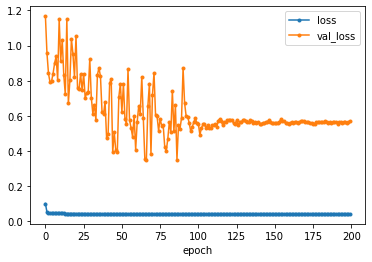

In [14]:
plot_history(history, ['loss', 'val_loss'])

## Computing Threshold Value
The network predicts 4 output channels:
1. The denoised input.
2. The foreground likelihoods.
3. The background likelihoods.
4. The border likelihoods.

We will threshold the foreground prediction image to obtain object segmentations. The optimal threshold is determined on the validation data. Additionally we can optimize the threshold for a given measure. In this case we choose the Average Precision (AP) measure.

In [15]:
threshold, val_score = model.optimize_thresholds(val_images.astype(np.float32), val_masks, measure=measure_precision())

print("The higest score of {} is achieved with threshold = {}.".format(np.round(val_score, 3), threshold))

Computing best threshold: 


/home/prakash/Desktop/GitClones/DenoiSeg/denoiseg/utils/compute_precision_threshold.py:7: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pixel_sharing_bipartite" failed type inference due to: Invalid use of Function(<built-in function zeros>) with argument(s) of type(s): (UniTuple(int64 x 2), dtype=Function(<class 'int'>))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at /home/prakash/Desktop/GitClones/DenoiSeg/denoiseg/utils/compute_precision_threshold.py (10)


File "../../denoiseg/utils/compute_precision_threshold.py", line 10:
def pixel_sharing_bipartite(lab1, lab2):
    <source elided>
    assert lab1.shape == lab2.shape
    psg = np.zero

Score for threshold = 0.10 is 0.0081
Score for threshold = 0.15 is 0.1588
Score for threshold = 0.20 is 0.4768
Score for threshold = 0.25 is 0.6597
Score for threshold = 0.30 is 0.7228
Score for threshold = 0.35 is 0.7457
Score for threshold = 0.40 is 0.7548
Score for threshold = 0.45 is 0.7555
Score for threshold = 0.50 is 0.7525
Score for threshold = 0.55 is 0.7496
Score for threshold = 0.60 is 0.7438
Score for threshold = 0.65 is 0.7391
Score for threshold = 0.70 is 0.7265
Score for threshold = 0.75 is 0.7124
Score for threshold = 0.80 is 0.6925
Score for threshold = 0.85 is 0.6614
Score for threshold = 0.90 is 0.6146
Score for threshold = 0.95 is 0.4960
Score for threshold = 1.00 is 0.0000

The higest score of 0.755 is achieved with threshold = 0.45000000000000007.


## Test Data
Finally we load the test data and run the prediction.

In [18]:
test_data =  np.load('data/Flywing_{}/test/test_data.npz'.format(noise_level), allow_pickle=True)
test_images = test_data['X_test']
test_masks = test_data['Y_test']

In [19]:
predicted_images, precision_result = model.predict_label_masks(test_images, test_masks, threshold, 
                                                                   measure=measure_precision())
print("Average precision over all test images with threshold = {} is {}.".format(threshold, np.round(precision_result, 3)))

Average precision over all test images with threshold = 0.45000000000000007 is 0.814.
